In [75]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN,MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score

In [76]:
df1 = pd.read_csv("dataset/cleaned_dataset.csv")
df2 = pd.read_csv("dataset/cleaned_dataset_v2.csv")

In [3]:
def split_data(df, target_column='Churn', test_size=0.2, random_state=42):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [77]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

Pour obtenir une classification robuste, il est possible de combiner la méthode de la Classification Ascendante Hiérarchique (CAH) avec celle des k-means. La CAH nous permettra de déterminer le nombre optimal de classes 𝑘, qui sera ensuite utilisé comme paramètre dans la méthode k-means pour affiner les clusters.

##### Recherche du nombre de cluster optimal

In [78]:
hc=linkage(df2,method="ward",metric='euclidean')
inertia = hc[-15:, 2]
# Calculer le nombre de clusters correspondant
num_clusters = range(1, len(inertia) + 1)

##### Visualisation du dendogramme et le diagramme de la perte d'inertie

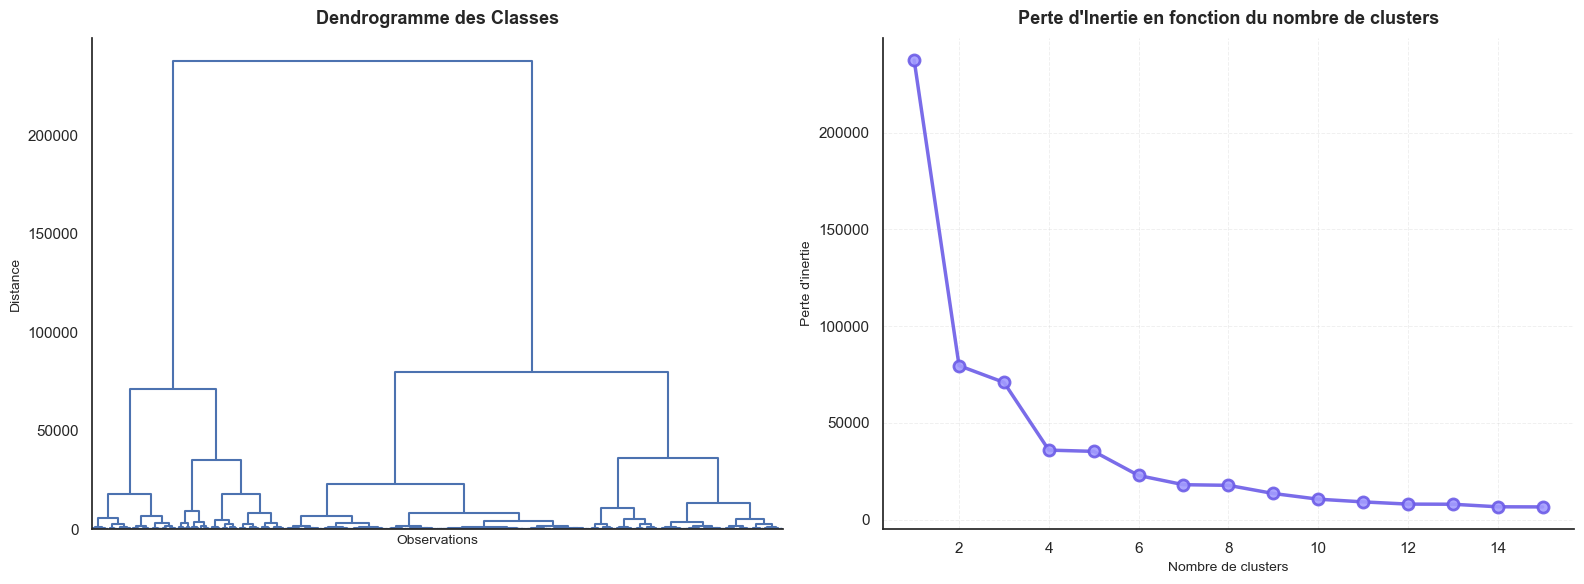

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Dendrogramme
dendrogram(hc, labels=None, color_threshold=0, ax=axes[0], no_labels=True)
axes[0].set_title("Dendrogramme des Classes", fontsize=13, fontweight='bold', pad=10)
axes[0].set_xlabel("Observations", fontsize=10)
axes[0].set_ylabel("Distance", fontsize=10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
# Courbe du coude 
axes[1].plot(num_clusters, inertia[::-1], marker='o', linewidth=2.5, markersize=8,color='#6c5ce7',markerfacecolor='#a29bfe',markeredgecolor='#6c5ce7',markeredgewidth=2,linestyle='-',alpha=0.9)
axes[1].set_title("Perte d'Inertie en fonction du nombre de clusters", fontsize=13, fontweight='bold', pad=10)
axes[1].set_xlabel("Nombre de clusters", fontsize=10)
axes[1].set_ylabel("Perte d'inertie", fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].set_axisbelow(True)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#fig.suptitle("Analyse de Clustering Hiérarchique", fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

Le tracé de la perte d'inertie nous incite à choisir une partition en 4 groupes (lecture de gauche à droite : juste avant le coude ou changement de pente s'opérant au passage de 3 à  4 groupes). 
Pour initialiser l'algorithme kmeans nous utilisons les résultats trouvés par la CAH : le nombre de classe optimal k=4 de la CAH. Ainsi nous obtenons: 

##### Méthode Kmeans

In [80]:
k=4
kmeans = KMeans(n_clusters=k, n_init=50)
kmeans.fit(df2)
label=kmeans.labels_
clusters = fcluster(hc, k, criterion='maxclust')
df_clusters = df2.copy()
df_clusters["Cluster"] = clusters

In [81]:
df_clusters.to_csv("dataset/cleaned_datasetclusters.csv")

Evaluation de la performance des clusters avec l'indice de Silhouette

In [73]:
sil_score = silhouette_score(df2, df_clusters["Cluster"], metric="euclidean")
print(f"Indice de silhouette global : {sil_score:.3f}")

Indice de silhouette global : 0.589


##### Visualisation des clusteurs avec l'algorithme TSNE

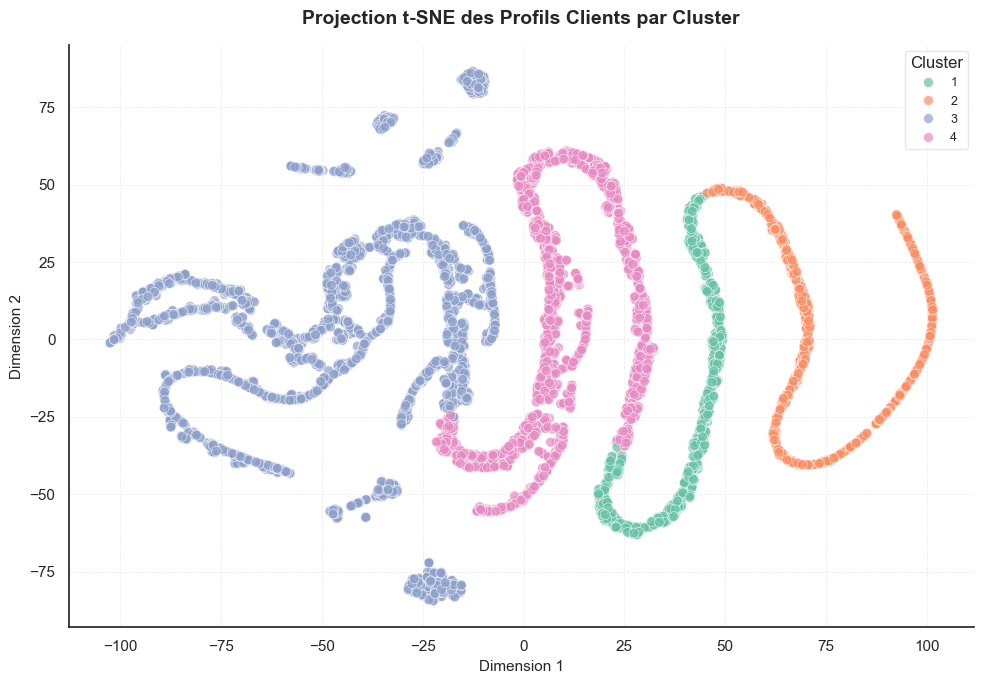

In [83]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(df2)
# Figure
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')
# Scatter plot
sns.scatterplot(x=X_tsne[:, 0],y=X_tsne[:, 1],hue=df_clusters["Cluster"],palette="Set2",s=50,alpha=0.7,edgecolor='white',linewidth=0.5,ax=ax)
# Styling
ax.set_title("Projection t-SNE des Profils Clients par Cluster", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Dimension 1", fontsize=11)
ax.set_ylabel("Dimension 2", fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
# Légende propre
legend = ax.legend(title="Cluster", frameon=True, loc='upper right', fontsize=9)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('#dfe6e9')
plt.tight_layout()
plt.show()